# Parametric Initial Value Problems in ODEs in CRONOS

The module `ODESLV` in `CRONOS` provides a wrapper to the code [CVODES](https://computing.llnl.gov/projects/sundials/cvodes) in [SUNDIALS](https://computing.llnl.gov/projects/sundials) for solving initial value problems in ODE systems with sensitivity analysis capabilities (both forward and adjoint modes). `CRONOS` leverages the DAG evaluation and automatic differentiation capability in `pyMC` to generates all the necessary function evaluations and derivatives internally. Conversely, the module `FFODE` in `CRONOS` enables such parametric inital value problems as external operations in a DAG. 

## Defining and Solving a Parametric ODE System

Suppose we want to compute the following two state-dependent functions:
$$\begin{align}
f_1(x_1^0,p) &= p\,x1(T)\,x_2(T)\\
f_2(x_1^0,p) &= \int_0^T x_1(t)^2 dt
\end{align}$$
at $T=10$, where the states $x_1(t)$ and $x_2(t)$ are solutions of the parametric ODE system:
$$\begin{align}
\dot{x}_1(t) &= p\, x_1(t)\, (1-x_2(t))\\
\dot{x}_2(t) &= p\, x_2(t)\, (x_1(t)-1)
\end{align}$$
for all $t\geq 0$, from the parametric initial conditions:
$$\begin{align}
x_1(0) &= x_1^0 \\
x_2(0) &= 1.1+0.01(p-3)
\end{align}$$

Suppose we want to compute the following two state-dependent functions:
$$\begin{align}
f_1(x_1^0,p) &= p\,x1(T)\,x_2(T)\\
f_2(x_1^0,p) &= \int_0^T x_1(t)^2 dt
\end{align}$$
at $T=10$, where the states $x_1(t)$ and $x_2(t)$ are solutions of the parametric ODE system:
$$\begin{align}
\dot{x}_1(t) &= p\, x_1(t)\, (1-x_2(t))\\
\dot{x}_2(t) &= p\, x_2(t)\, (x_1(t)-1)
\end{align}$$
for all $t\geq 0$, from the parametric initial conditions:
$$\begin{align}
x_1(0) &= x_1^0 \\
x_2(0) &= 1.1+0.01(p-3)
\end{align}$$

We start by importing both the `PyMC` and `CRONOS` libraries:

In [1]:
import pymc
import cronos

The DAGs of the right-hand side and initial value functions as well as the state-dependent functions are defined:

In [2]:
DAG = pymc.FFGraph()
X1  = pymc.FFVar(DAG,"X1")
X2  = pymc.FFVar(DAG,"X2")
Z   = pymc.FFVar(DAG,"Z")
Q   = pymc.FFVar(DAG,"Q" )
P   = pymc.FFVar(DAG,"P" )
X10 = pymc.FFVar(DAG,"X10" )

An environment `ODESLV` is created and populated with the parametric initial value problem:

In [3]:
IVP = cronos.ODESLV()
IVP.set_dag( DAG )
IVP.set_time( [0,10] )
IVP.set_state( [X1,X2] )
IVP.set_parameter( [P,X10] )
Z = P*X1*(1-X2)
IVP.set_differential( [Z, P*X2*(X1-1)] )
IVP.set_initial( [X10, 1.1+0.01*(P-3)] )
IVP.set_quadrature( [pymc.sqr(X1)], [Q] )
IVP.set_function( [ P*X1*X2, Q ] )
IVP.setup()

Values of the state-dependent functions can be computed at given values of $p$ and $x_1^0$ using the `solve_state` method:

In [4]:
IVP.solve_state( [2.95,1.2] )

 @t = 0.000000e+00 :
  x[0] = 1.200000e+00
  x[1] = 1.099500e+00
  q[0] = 0.000000e+00
 @t = 1.000000e+01 :
  x[0] = 9.955286e-01
  x[1] = 8.033584e-01
  q[0] = 1.000542e+01
  f[0] = 2.359311e+00
  f[1] = 1.000542e+01
 No STEPS    403
 No EVALATIONS   RHS: 472   JAC: 0
 CPU TIME (SEC)     0.00082



<ODESLV.STATUS.NORMAL: 0>

An environment `ODESLV` is created and populated with the parametric initial value problem:

In [5]:
IVP = cronos.ODESLV()
IVP.set_dag( DAG )
IVP.set_time( [0,10] )
IVP.set_state( [X1,X2] )
IVP.set_parameter( [P,X10] )
IVP.set_differential( [P*X1*(1-X2), P*X2*(X1-1)] )
IVP.set_initial( [X10, 1.1+0.01*(P-3)] )
IVP.set_quadrature( [pymc.sqr(X1)], [Q] )
IVP.set_function( [ P*X1*X2, Q ] )
IVP.setup()

Values of the state-dependent functions can be computed at given values of $p$ and $x_1^0$ using the `solve_state` method:

In [6]:
IVP.solve_state( [2.95, 1.2] ) 

 @t = 0.000000e+00 :
  x[0] = 1.200000e+00


<ODESLV.STATUS.NORMAL: 0>

  x[1] = 1.099500e+00
  q[0] = 0.000000e+00
 @t = 1.000000e+01 :
  x[0] = 9.955286e-01
  x[1] = 8.033584e-01
  q[0] = 1.000542e+01
  f[0] = 2.359311e+00
  f[1] = 1.000542e+01
 No STEPS    403
 No EVALATIONS   RHS: 472   JAC: 0
 CPU TIME (SEC)     0.00081



Values of the states and functions can be retrieved using the `val_state` and `val_function` methods:

In [7]:
print( "x = ", IVP.val_state )
print( "f = ", IVP.val_function )

x =  [[1.2, 1.0995000000000001], [0.9955286269847439, 0.803358412473127]]
f =  [2.3593105771707465, 10.005420838592904]


Further time stages can be added along the integration horizon through the `set_time` method:

In [8]:
IVP.set_time( [0,2,4,6,8,10] )
IVP.setup()
IVP.solve_state( [2.95,1.2] )

 @t = 0.000000e+00 :
  x[0] = 1.200000e+00
  x[1] = 1.099500e+00
  q[0] = 0.000000e+00


<ODESLV.STATUS.NORMAL: 0>

 @t = 2.000000e+00 :
  x[0] = 1.226315e+00
  x[1] = 1.006668e+00
  q[0] = 1.981334e+00
 @t = 4.000000e+00 :
  x[0] = 1.207636e+00
  x[1] = 9.203342e-01
  q[0] = 1.980140e+00
 @t = 6.000000e+00 :
  x[0] = 1.152633e+00
  x[1] = 8.544963e-01
  q[0] = 1.992683e+00
 @t = 8.000000e+00 :
  x[0] = 1.076774e+00
  x[1] = 8.152123e-01
  q[0] = 2.013815e+00
 @t = 1.000000e+01 :
  x[0] = 9.955240e-01
  x[1] = 8.033562e-01
  q[0] = 2.037447e+00
  f[0] = 2.359293e+00
  f[1] = 2.037447e+00
 No STEPS    499
 No EVALATIONS   RHS: 608   JAC: 0
 CPU TIME (SEC)     0.00046



Trajectories can furthermore be recorded at a specified number of timepoints by setting the `RESRECORD` option accordingly:  

In [9]:
IVP.options.DISPLEVEL = 0
IVP.options.RESRECORD = 200
IVP.set_time( [0,10] )
IVP.setup()
IVP.solve_state( [2.95,1.2] )

<ODESLV.STATUS.NORMAL: 0>

In [10]:
import numpy as np
import matplotlib.pyplot as plt

The records can be retrieved from the `results_state` field:

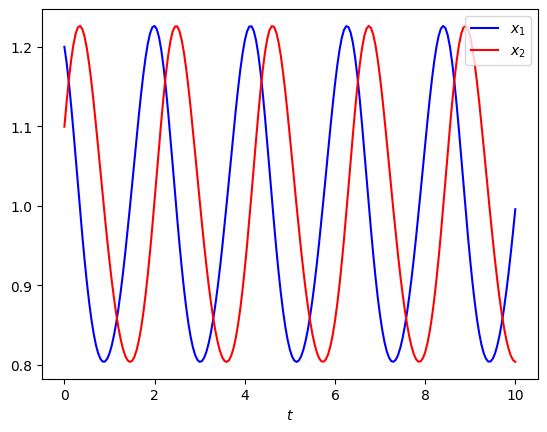

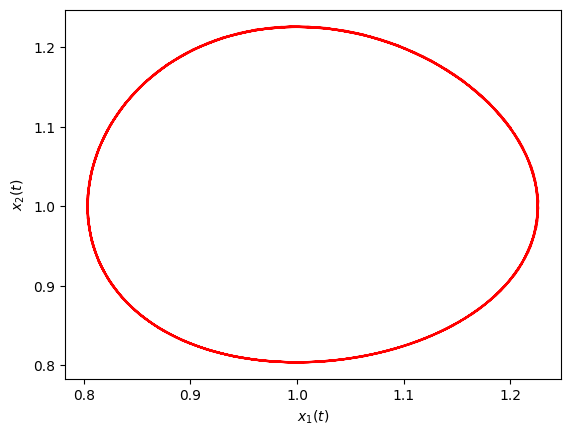

In [11]:
results = []
for rec in IVP.results_state:
  results.append( [rec.t] + rec.x )
results = np.array( results )

plt.xlabel('$t$')
plt.plot(results[:,0], results[:,1], "-b", label="$x_1$")
plt.plot(results[:,0], results[:,2], "-r", label="$x_2$")
plt.legend(loc="best")
plt.show()

plt.xlabel('$x_1(t)$')
plt.ylabel('$x_2(t)$')
plt.plot(results[:,1], results[:,2], "-r")
plt.show()


## Conducting Sensitivity Analysis of a Parametric ODE System

Suppose now we want to compute the derivatives of the same two state-dependent functions:
$$\begin{align}
f_1(x_1^0,p) &= p\,x1(T)\,x_2(T)\\
f_2(x_1^0,p) &= \int_0^T x_1(t)^2 dt
\end{align}$$
at $T=10$, where the states $x_1(t)$ and $x_2(t)$ are solutions of the parametric ODE system:
$$\begin{align}
\dot{x}_1(t) &= p\, x_1(t)\, (1-x_2(t))\\
\dot{x}_2(t) &= p\, x_2(t)\, (x_1(t)-1)
\end{align}$$
for all $t\geq 0$, from the parametric initial conditions:
$$\begin{align}
x_1(0) &= x_1^0 \\
x_2(0) &= 1.1+0.01(p-3)
\end{align}$$

Such derivatives can be computed at given values of $p$ and $x_1^0$ using:
- forward sensitivity analysis via the `solve_sensitivity` method:

df =  [[5.336411565973853, -0.033147247681526826], [-3.27072846386273, 1.0840924280943427]]
 @t = 0.000000e+00 :
  x[0] = 1.200000e+00
  x[1] = 1.099500e+00
  q[0] = 0.000000e+00
  xp[0][0] = 0.000000e+00
  xp[0][1] = 1.000000e-02
  qp[0][0] = 0.000000e+00
  xp[1][0] = 1.000000e+00
  xp[1][1] = 0.000000e+00
  qp[1][0] = 0.000000e+00
 @t = 1.000000e+01 :
  x[0] = 9.955247e-01
  x[1] = 8.033577e-01
  q[0] = 1.000542e+01
  xp[0][0] = 1.963542e+00
  xp[0][1] = -3.975707e-02
  qp[0][0] = -3.314725e-02
  xp[1][0] = -5.488263e-01
  xp[1][1] = -6.708198e-01
  qp[1][0] = 1.084092e+00
  f[0] = 2.359299e+00
  f[1] = 1.000542e+01
  fp[0][0] = 5.336412e+00
  fp[0][1] = -3.314725e-02
  fp[1][0] = -3.270728e+00
  fp[1][1] = 1.084092e+00
 No STEPS    813
 No EVALATIONS   RHS: 1972   JAC: 0
 CPU TIME (SEC)     0.00212



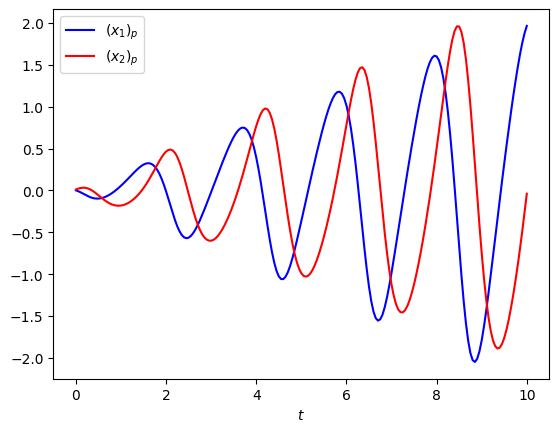

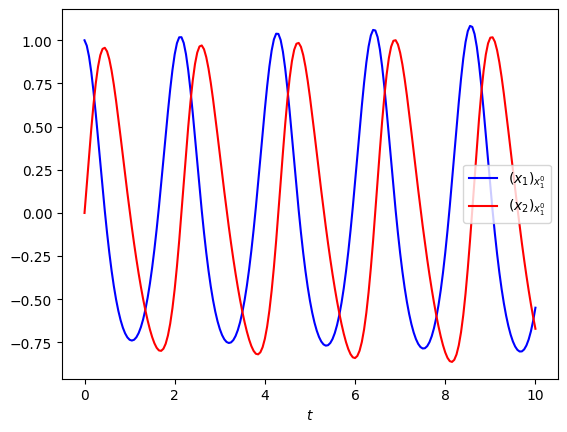

In [12]:
IVP.options.DISPLEVEL = 1
IVP.options.RESRECORD = 200
IVP.solve_sensitivity( [2.95,1.2] )
print( "df = ", IVP.val_function_gradient )

results = []
for rec in IVP.results_sensitivity[0]:
  results.append( [rec.t] + rec.x )
results = np.array( results )

plt.xlabel('$t$')
plt.plot(results[:,0], results[:,1], "-b", label="$(x_1)_p$")
plt.plot(results[:,0], results[:,2], "-r", label="$(x_2)_p$")
plt.legend(loc="best")
plt.show()

results = []
for rec in IVP.results_sensitivity[1]:
  results.append( [rec.t] + rec.x )
results = np.array( results )

plt.xlabel('$t$')
plt.plot(results[:,0], results[:,1], "-b", label="$(x_1)_{x_1^0}$")
plt.plot(results[:,0], results[:,2], "-r", label="$(x_2)_{x_1^0}$")
plt.legend(loc="best")
plt.show()

- adjoint sensitivity analysis via the `solve_adjoint` method:

df =  @t = 0.000000e+00 :
  x[0] = 1.200000e+00
  x[1] = 1.099500e+00
  q[0] = 0.000000e+00
 @t = 1.000000e+01 :
  x[0] = 9.955547e-01
  x[1] = 8.034524e-01
  q[0] = 1.000539e+01
  f[0] = 2.359648e+00
  f[1] = 1.000539e+01
 No STEPS    463
 No EVALATIONS   RHS: 610   JAC: 0
 CPU TIME (SEC)     0.00151

 @t = 1.000000e+01 :
  l[0][0] = 2.370185e+00
  l[0][1] = 2.936886e+00
  qp[0][0] = 7.998808e-01
  qp[0][1] = 0.000000e+00
  l[1][0] = 0.000000e+00
  l[1][1] = 0.000000e+00
  qp[1][0] = 0.000000e+00
  qp[1][1] = 0.000000e+00
 @t = 0.000000e+00 :
  l[0][0] = -3.270260e+00
  l[0][1] = 2.860094e-01
  qp[0][0] = 5.335979e+00
  qp[0][1] = -3.270260e+00
  l[1][0] = 1.083617e+00
  l[1][1] = -1.035453e-01
  qp[1][0] = -3.290262e-02
  qp[1][1] = 1.083617e+00
  fp[0][0] = 5.335979e+00
  fp[0][1] = -3.290262e-02
  fp[1][0] = -3.270260e+00
  fp[1][1] = 1.083617e+00
 No STEPS    1383
 No EVALATIONS   RHS: 1848   JAC: 0
 CPU TIME (SEC)     0.00194

 [[5.335978609430741, -0.03290262381155513], [-3.2702

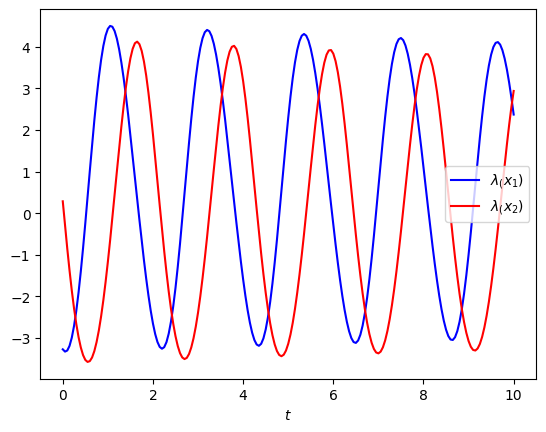

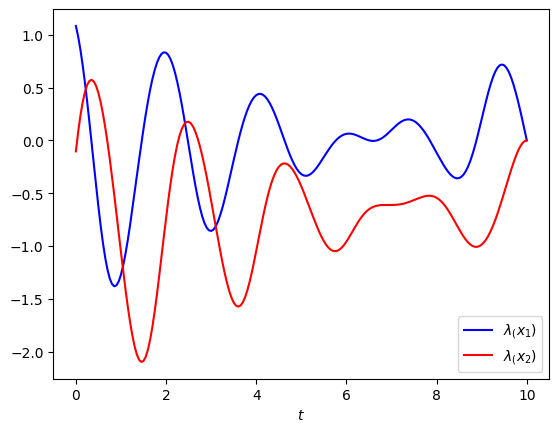

In [13]:
IVP.options.DISPLEVEL = 1
IVP.options.RESRECORD = 200
IVP.solve_adjoint( [2.95,1.2] )
print( "df = ", IVP.val_function_gradient )

results = []
for rec in IVP.results_sensitivity[0]:
  results.append( [rec.t] + rec.x )
results = np.array( results )

plt.xlabel('$t$')
plt.plot(results[:,0], results[:,1], "-b", label=r'$\lambda_(x_1)$')
plt.plot(results[:,0], results[:,2], "-r", label=r'$\lambda_(x_2)$')
plt.legend(loc="best")
plt.show()

results = []
for rec in IVP.results_sensitivity[1]:
  results.append( [rec.t] + rec.x )
results = np.array( results )

plt.xlabel('$t$')
plt.plot(results[:,0], results[:,1], "-b", label=r'$\lambda_(x_1)$')
plt.plot(results[:,0], results[:,2], "-r", label=r'$\lambda_(x_2)$')
plt.legend(loc="best")
plt.show()

## Embedding a Parametric ODE System in an Expression Tree

The module `FFODE` in enables embedding a parametric ODE system as external operation in a DAG:

In [14]:
OpIVP = cronos.FFODE()
IVP.options.DISPLEVEL = 0
IVP.options.RESRECORD = 0
F = OpIVP( [P,X10], IVP )
DAG.output( F )


OPERATIONS IN SUBGRAPH:
  P	<<  VARIABLE
  X10	<<  VARIABLE
  Z17	<<  ODE[0x253c22d0]( P, X10 )	[0]
  Z18	<<  ODE[0x253c22d0]( P, X10 )	[1]
DEPENDENTS IN SUBGRAPH:
  0:  Z17
  1:  Z18
WORK ARRAY SIZE: 6
MOVE ARRAY SIZE: 2


This augmented DAG can be evaluated as any other DAG using the `eval` method:

In [15]:
D_F = DAG.eval( F, [P,X10], [2.95,1.2] )
print( "f =", D_F )

f = [2.3593105771707465, 10.005420838592904]


Symbolic differentiation may also be conducted on the augmented DAG using both the `fdiff` and `bdiff` methods:

In [16]:
[Row,Col,dF]   = DAG.fdiff( F, [P,X10] )
DAG.output( dF )

D_dF = DAG.eval( dF, [P,X10], [2.95,1.2] )
print( "df =", D_dF )

df = [5.336412064041133, -0.033146196850153686, -3.2707227862069415, 1.084094730658011]

OPERATIONS IN SUBGRAPH:
  P	<<  VARIABLE
  X10	<<  VARIABLE
  Z19	<<  GRADODE[0x253e7640]( P, X10 )	[0]
  Z20	<<  GRADODE[0x253e7640]( P, X10 )	[1]
  Z21	<<  GRADODE[0x253e7640]( P, X10 )	[2]
  Z22	<<  GRADODE[0x253e7640]( P, X10 )	[3]
DEPENDENTS IN SUBGRAPH:
  0:  Z19
  1:  Z20
  2:  Z21
  3:  Z22
WORK ARRAY SIZE: 8
MOVE ARRAY SIZE: 2


Multiple DAG evaluations can also be conducted on parallel threads using the `veval` method:

In [17]:
import time
from scipy.stats import qmc
sampler = qmc.Sobol(d=2, scramble=False, seed=2)
samPX10 = sampler.random_base2(m=14) # 2^16 ~ 65,500 evaluations 
samPX10[:,0] = 2.9 + samPX10[:,0] * 0.1
samPX10[:,1] = 1.1 + samPX10[:,1] * 0.2

#print( samX )
#print(samX.tolist())

In [18]:
DAG.options.MAXTHREAD = 1
start = time.time()
samF = DAG.veval( F, [P,X10], samPX10.tolist() )
end = time.time()
print("veval walltime with 1 thread: ", end - start)
#print(samF)

DAG.options.MAXTHREAD = 2
start = time.time()
samF = DAG.veval( F, [P,X10], samPX10.tolist() )
end = time.time()
print("veval walltime with 2 threads: ", end - start)

DAG.options.MAXTHREAD = 3
start = time.time()
samF = DAG.veval( F, [P,X10], samPX10.tolist() )
end = time.time()
print("veval walltime with 3 threads: ", end - start)

DAG.options.MAXTHREAD = 0 # all available threads
start = time.time()
samF = DAG.veval( F, [P,X10], samPX10.tolist() )
end = time.time()
print("veval walltime with all threads: ", end - start)
#print(samF)

veval walltime with 1 thread:  5.3929829597473145
veval walltime with 2 threads:  2.9287474155426025
veval walltime with 3 threads:  2.0738420486450195
veval walltime with all threads:  0.7263033390045166


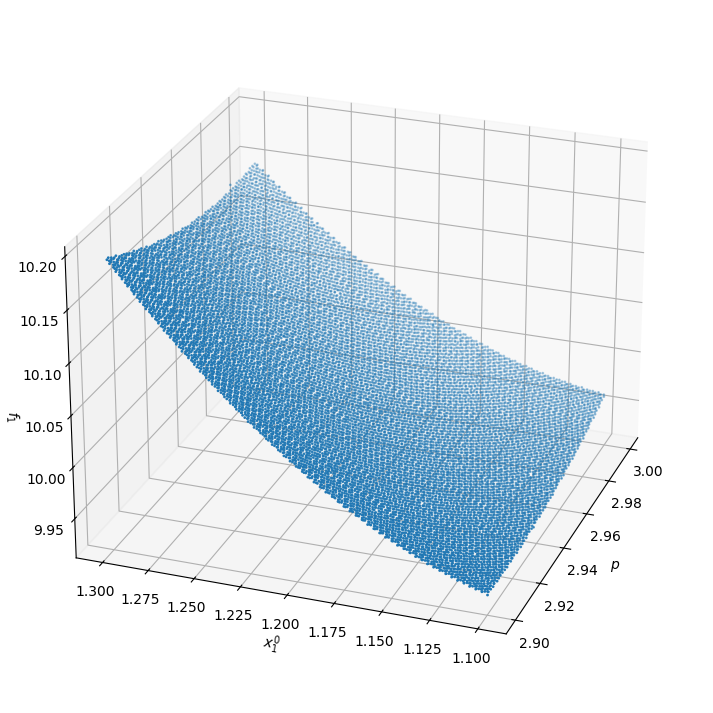

In [19]:
samF = np.array( samF )

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$x_1^0$')
ax.set_zlabel(r'$f_1$')

#ax.scatter(samPX10[:,0], samPX10[:,1], samF[:,0])
ax.scatter(samPX10[:,0], samPX10[:,1], samF[:,1], s=1)
ax.view_init(elev=25, azim=200)

plt.show()

### Embedding Multiple Parametric ODE Systems in an Expression Tree

Consider now the problem of computing averaged function values over a range of initial values $x_1^0,\ldots,x_1^N$:
$$\begin{align}
\bar{f}_1(p) &= \frac{1}{N} \sum_{k=0}^N p\,x^k_1(T)\,x^k_2(T)\\
\bar{f}_2(p) &= \frac{1}{N} \sum_{i=0}^N \int_0^T x^k_1(t)^2 dt
\end{align}$$
at $T=10$, where the states $x^k_1(t)$ and $x^k_2(t)$ are solutions of the parametric ODE system:
$$\begin{align}
\dot{x}^k_1(t) &= p\, x^k_1(t)\, (1-x^k_2(t))\\
\dot{x}^k_2(t) &= p\, x^k_2(t)\, (x^k_1(t)-1)
\end{align}$$
for all $t\geq 0$, from the parametric initial conditions:
$$\begin{align}
x^k_1(0) &= x_1^k \\
x^k_2(0) &= 1.1+0.01(p-3)
\end{align}$$

We start by creating a list of DAG variables corresponding to the initial values $x_1^0,\ldots,x_1^N$:

In [20]:
N = 2**10 # number of samples
samX10 = [pymc.FFVar(DAG,"X1_"+str(i)) for i in range(N)]
#print( samX10 )

Next, we create copies of the parametric ODE system, where $p$ is the parameter and the initial conditions $x_1^k$ are defined as constants, and we embed all these parametric ODE systems as external operations in the DAG:

In [21]:
F = []
for i in range(N):
    IVPi = cronos.ODESLV()
    IVPi.set( IVP )
    IVPi.set_parameter( [P] )
    IVPi.set_constant( [X10] )
    IVPi.options = IVP.options
    IVPi.setup()
    F += OpIVP( [P], [samX10[i]], IVPi )

#DAG.output( F )

In [22]:
start = time.time()
D_F = DAG.eval( F, [P]+samX10, [2.95]+[1.1+0.2*i/N for i in range(N)] )
end = time.time()
print("eval walltime with ", N, " samples: ", end - start)
print( "f =", [sum(D_F[0::2])/N, sum(D_F[1::2])/N] )

eval walltime with  1024  samples:  0.3600339889526367
f = [2.3651400495811283, 10.017969666130302]


In [23]:
M=8
FF = pymc.Vect( DAG, [P]+samX10, [F[IVP.nf*m*N//M:IVP.nf*(m+1)*N//M] for m in range(M)] )
OpVec = pymc.FFVect()
Fvec = OpVec( FF )
#DAG.output( Fvec )

#D_F = DAG.eval( Fvec, [P]+samX10, [2.95]+[1.1+0.2*i/N for i in range(N)] )
#print( "f =", D_F )

In [24]:
OpSum = pymc.FFSum()
Fave = [OpSum(Fvec[0::IVP.nf])/N, OpSum(Fvec[1::IVP.nf])/N]
#DAG.output( Fave )

start = time.time()
D_F = DAG.eval( Fave, [P]+samX10, [2.95]+[1.1+0.2*i/N for i in range(N)] )
end = time.time()
print("eval walltime with ", N, " samples and ", M, " threads: ", end - start)
print( "f =", D_F )

eval walltime with  1024  samples and  8  threads:  0.07630634307861328
f = [2.365140049581125, 10.017969666130302]


## Defining a Multistage Parametric ODE System

Now, suppose we want to compute the following two state-dependent functions:
$$\begin{align}
f_1(x_1^0,p_1,p_2,p_3) &= \sum_{k=1}^3 p_k\,x1(T_k^-)\,x_2(T_k^-)\\
f_2(x_1^0,p_1,p_2,p_3) &= \sum_{k=1}^3 \int_{T_{k-1}^+}^{T_k^-} x_1(t)^2 dt
\end{align}$$
with $T_k=10\frac{k}{3},\ k=1,3$, for a multistage parametric ODE system in the state variables $[x_1(t),x_2(t)]$ given by:
$$\begin{align}
\dot{x}_1(t) &= p_k\, x_1(t)\, (1-x_2(t))\\
\dot{x}_2(t) &= p_k\, x_2(t)\, (x_1(t)-1)
\end{align}$$
for all $t\in[T_{k-1},T_k),\ k=1\ldots 3$, from the parametric initial conditions:
$$\begin{align}
x_1(0) &= x_1^0 \\
x_2(0) &= 1.1+0.01(p-3)
\end{align}$$
and with the following state discontinuities at $t=T_k,\ k=1,2$:
$$\begin{align}
x_1(T_k^+) &= x_1(T_k^-) \\
x_2(T_k^+) &= x_2(T_k^-) + 0.01 p_k
\end{align}$$

The DAGs of the right-hand side, initial value and discontinuity functions as well as the state-dependent functions are given by:

In [25]:
import pymc
import cronos

In [26]:
DAG = pymc.FFGraph()
NS = 3
X10 = pymc.FFVar(DAG,"X10" )
X1, X2 = pymc.FFVar(DAG,"X1"), pymc.FFVar(DAG,"X2")
Q = pymc.FFVar(DAG,"Q")
QUAD = pymc.sqr(X1)
P    = []
IC   = []
RHS  = []
F    = []
for k in range(NS):
  P.append( pymc.FFVar(DAG,"P"+str(k)) )
  if k==0:
    IC.append( [X10, 1.1+0.01*(P[0]-3)] ) 
  else:
    IC.append( [X1, X2] )#+0.1] ) #*P[k]] )
  RHS.append( [P[k]*X1*(1-X2), P[k]*X2*(X1-1)] )
  F.append( [P[k]*X1*X2] )#, Q] )
P.append( X10 )

In [27]:
import numpy as np
IVPMS = cronos.ODESLV()
IVPMS.set_dag( DAG )
IVPMS.set_time( np.arange(0, 10+1e-10, 10/NS).tolist() )
IVPMS.set_state( [X1, X2] )
IVPMS.set_parameter( P )
IVPMS.set_differential( RHS )
IVPMS.set_initial( IC )
IVPMS.set_quadrature( [QUAD], [Q] )
IVPMS.set_function( F )
IVPMS.setup()

In [28]:
IVPMS.options.DISPLEVEL = 1
IVPMS.options.RESRECORD = 200
IVPMS.solve_state( [3,2.5,3.5,1.2] )

 @t = 0.000000e+00 :
  x[0] = 1.200000e+00
  x[1] = 1.100000e+00
  q[0] = 0.000000e+00


<ODESLV.STATUS.NORMAL: 0>

 @t = 3.333333e+00 :
  x[0] = 8.932880e-01
  x[1] = 8.304666e-01
  q[0] = 3.219275e+00
 @t = 6.666667e+00 :
  x[0] = 1.223643e+00
  x[1] = 9.669695e-01
  q[0] = 3.524709e+00
 @t = 1.000000e+01 :
  x[0] = 1.095592e+00
  x[1] = 8.217379e-01
  q[0] = 3.312408e+00
  f[0] = 8.334614e+00
 No STEPS    187
 No EVALATIONS   RHS: 591   JAC: 0
 CPU TIME (SEC)     0.00131



In [29]:
import numpy as np
import matplotlib.pyplot as plt

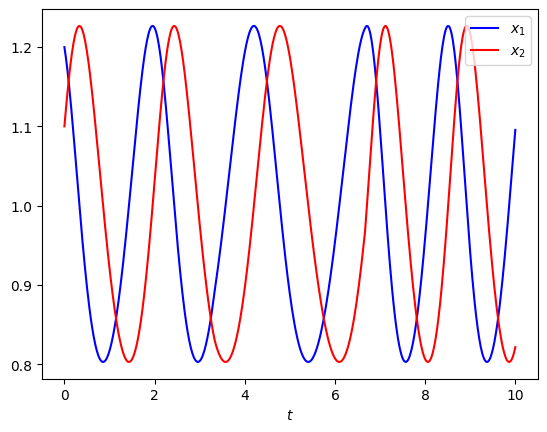

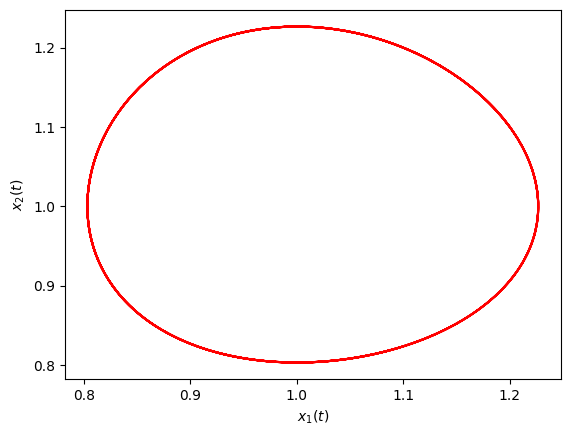

In [30]:
results = []
for rec in IVPMS.results_state:
  results.append( [rec.t] + rec.x )
results = np.array( results )

plt.xlabel('$t$')
plt.plot(results[:,0], results[:,1], "-b", label="$x_1$")
plt.plot(results[:,0], results[:,2], "-r", label="$x_2$")
plt.legend(loc="best")
plt.show()

plt.xlabel('$x_1(t)$')
plt.ylabel('$x_2(t)$')
plt.plot(results[:,1], results[:,2], "-r")
plt.show()


In [31]:
IVPMS.solve_adjoint( [3,2.5,3.5,1.2] )
print( "df = ", IVPMS.val_function_gradient )

df =  [[6.638064762982152], [6.570104190120413], [3.9068400753892782], [-6.691756771614777]]
 @t = 0.000000e+00 :
  x[0] = 1.200000e+00
  x[1] = 1.100000e+00
  q[0] = 0.000000e+00
 @t = 3.333333e+00 :
  x[0] = 8.932880e-01
  x[1] = 8.304666e-01
  q[0] = 3.219275e+00
 @t = 6.650000e+00 :
  x[0] = 1.223643e+00
  x[1] = 9.669695e-01
  q[0] = 3.499791e+00
 @t = 1.000000e+01 :
  x[0] = 1.106890e+00
  x[1] = 8.266058e-01
  q[0] = 3.332621e+00
  f[0] = 8.385967e+00
 No STEPS    188
 No EVALATIONS   RHS: 593   JAC: 0
 CPU TIME (SEC)     0.00146

 @t = 1.000000e+01 :
  l[0][0] = 2.893120e+00
  l[0][1] = 3.874114e+00
  qp[0][0] = 0.000000e+00
  qp[0][1] = 0.000000e+00
  qp[0][2] = 9.149615e-01
  qp[0][3] = 0.000000e+00
 @t = 6.666667e+00 :
  l[0][0] = 1.076617e+00
  l[0][1] = 7.271703e+00
  qp[0][0] = 0.000000e+00
  qp[0][1] = 1.183226e+00
  qp[0][2] = 3.906840e+00
  qp[0][3] = 0.000000e+00
RESTARTING FORWARD INTEGRATION at t=3.333333e+00
 @t = 3.333333e+00 :
  l[0][0] = 1.068527e+01
  l[0][1] =

In [32]:
IVPMS.solve_sensitivity( [3,2.5,3.5,1.2] )
print( "df = ", IVPMS.val_function_gradient )

df =  [[6.658846983878893], [6.590438055688103], [3.776652266072643], [-6.6615924885725155]]
 @t = 0.000000e+00 :
  x[0] = 1.200000e+00
  x[1] = 1.100000e+00
  q[0] = 0.000000e+00
  xp[0][0] = 0.000000e+00
  xp[0][1] = 1.000000e-02
  qp[0][0] = 0.000000e+00
  xp[1][0] = 0.000000e+00
  xp[1][1] = 0.000000e+00
  qp[1][0] = 0.000000e+00
  xp[2][0] = 0.000000e+00
  xp[2][1] = 0.000000e+00
  qp[2][0] = 0.000000e+00
  xp[3][0] = 1.000000e+00
  xp[3][1] = 0.000000e+00
  qp[3][0] = 0.000000e+00
 @t = 3.333333e+00 :
  x[0] = 8.932877e-01
  x[1] = 8.304675e-01
  q[0] = 3.219275e+00
  xp[0][0] = 5.079432e-01
  xp[0][1] = -3.016935e-01
  qp[0][0] = -1.949677e-01
  xp[1][0] = 0.000000e+00
  xp[1][1] = 0.000000e+00
  qp[1][0] = 0.000000e+00
  xp[2][0] = 0.000000e+00
  xp[2][1] = 0.000000e+00
  qp[2][0] = 0.000000e+00
  xp[3][0] = -6.865512e-01
  xp[3][1] = -4.146700e-01
  qp[3][0] = 2.248206e-01
 @t = 6.666667e+00 :
  x[0] = 1.223642e+00
  x[1] = 9.669689e-01
  q[0] = 3.524707e+00
  xp[0][0] = 1.408

## Parameters _vs_ Constants in a Parametric ODE System